# Chosing location for a new oil well for GlavRosGosNeft

GlavRosGosNeft needs to decide where to drill a new well.
In selected regions, characteristics for wells are collected: oil quality and the volume of its reserves;

Task:
- Build a model to predict the amount of reserves in new wells;
- Select the wells with the highest values;
- Determine the region with maximum total profit of the selected wells.
- Analyze possible profits and risks with Bootstrap technology.

### Conditions:

- Only linear regression is suitable for model training (the rest are not sufficiently predictable).
- In the exploration of the region, 500 points are investigated, from which the 200 best are selected for development using machine learning.
- The budget for the development of wells in the region - 10 billion rubles.
- At current prices, one barrel of raw materials brings 450 rubles of income. Income from each unit of product is 450 thousand rubles, since the volume is indicated in thousands of barrels.
- After risk assessment it is necessary to leave only those regions where the probability of losses is less than 2.5%. Among them, they choose the region with the highest average profit.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.3f}'.format
%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy.random import RandomState
from scipy import stats as st


import warnings
import seaborn as sns
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

In [3]:
cwd = os.getcwd()

In [4]:
try:
    df0 = pd.read_csv(cwd + '/geo_data_0.csv')
    df1 = pd.read_csv(cwd + '/geo_data_1.csv')
    df2 = pd.read_csv(cwd + '/geo_data_2.csv')
except:
    df0 = pd.read_csv('/datasets/geo_data_0.csv')
    df1 = pd.read_csv('/datasets/geo_data_1.csv')
    df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
df0.info(), df1.info(), df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8

(None, None, None)

There are no Nans in the data, we'll remove the column with id and use StandartScaler to simplify the task for the models

In [6]:
display(df0.sample(), df1.sample(), df2.sample())

,id,f0,f1,f2,product
94256,sNlLP,0.724,0.716,4.654,154.183


,id,f0,f1,f2,product
57381,fVvi4,-10.011,-14.299,3.008,84.039


,id,f0,f1,f2,product
66665,tbWLt,0.009,0.609,-5.822,34.420


## Обзор

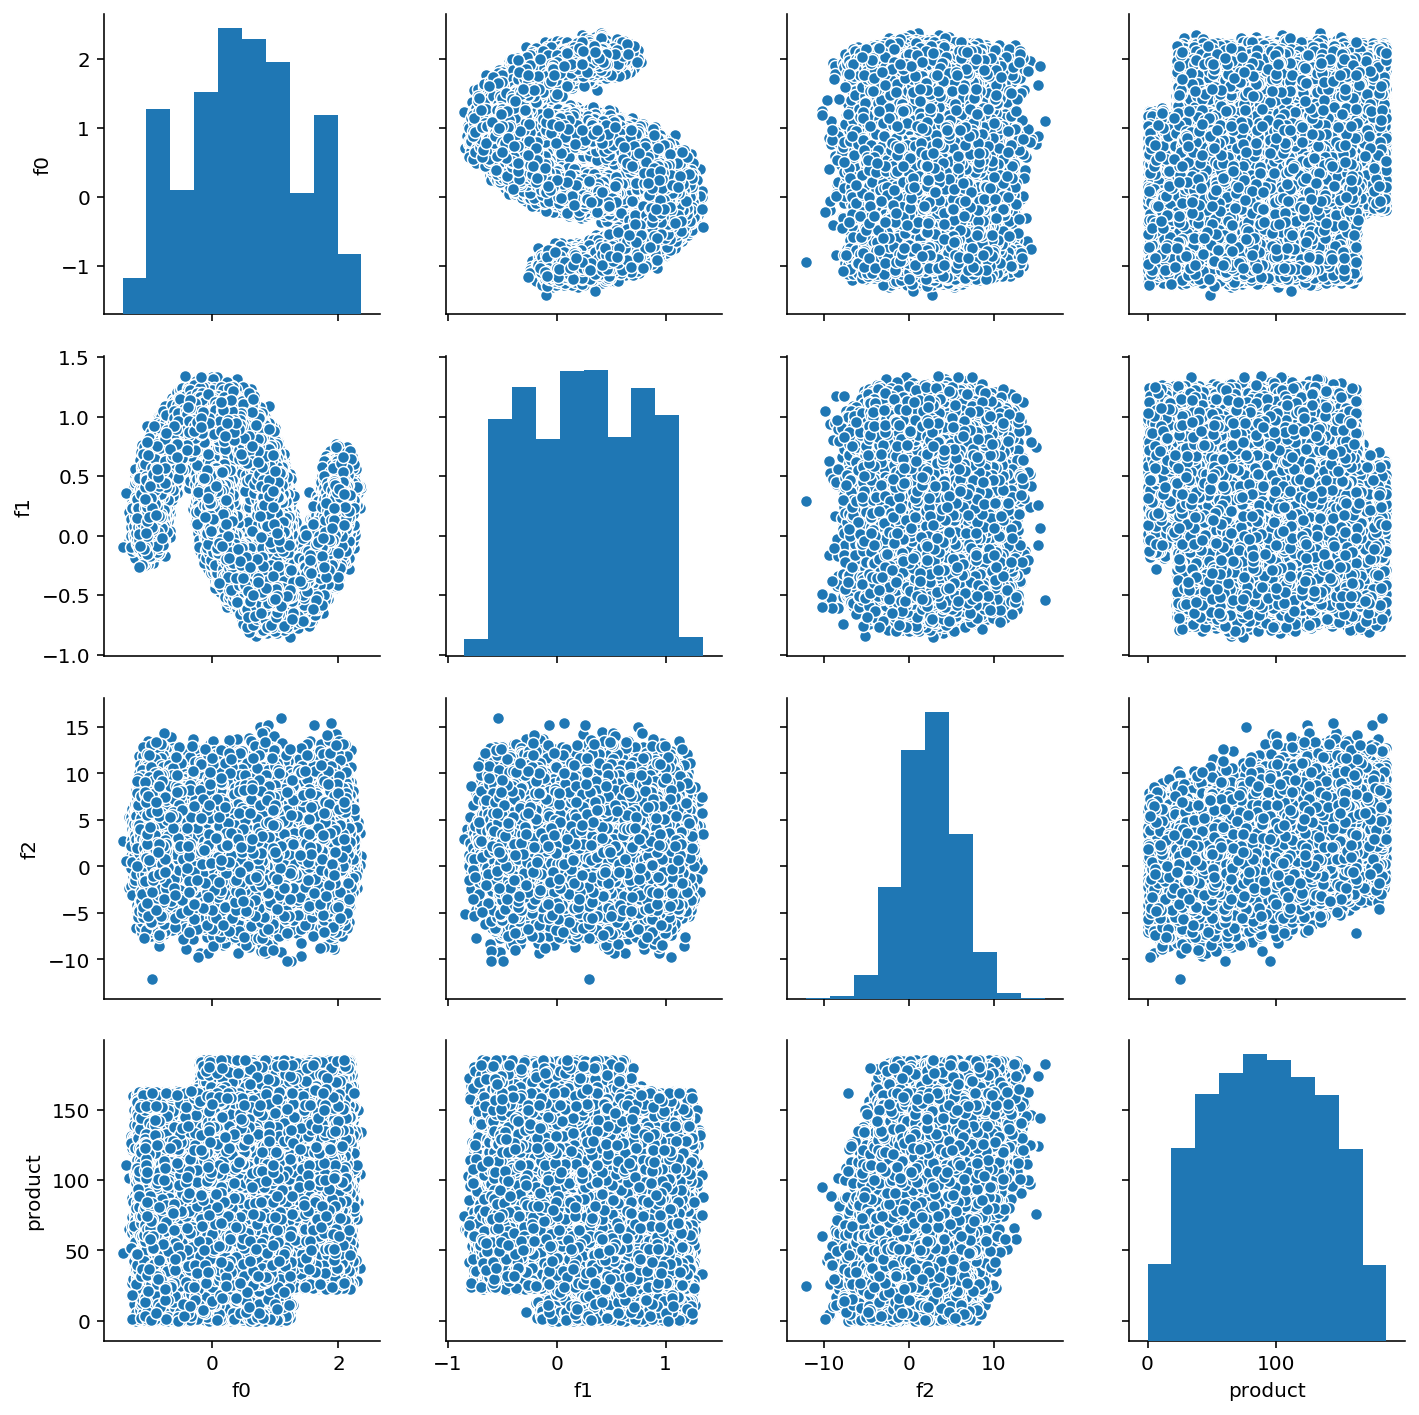

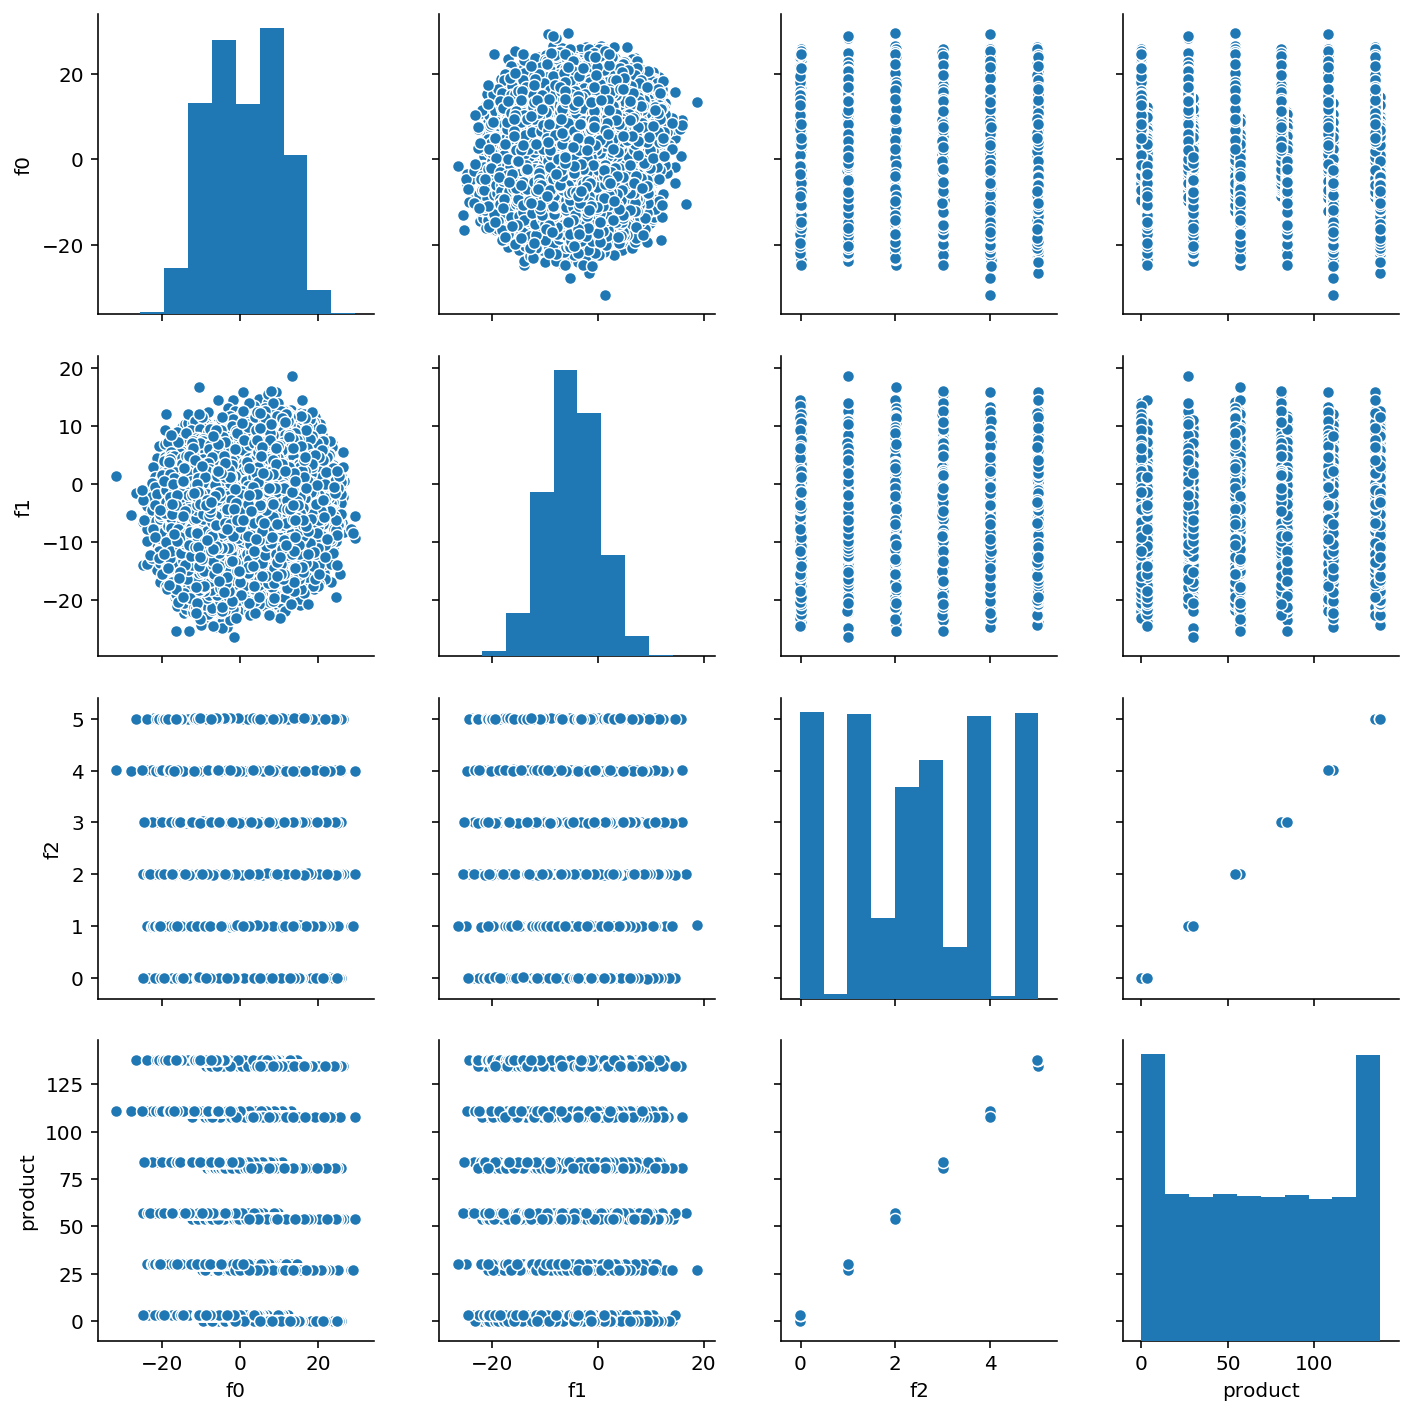

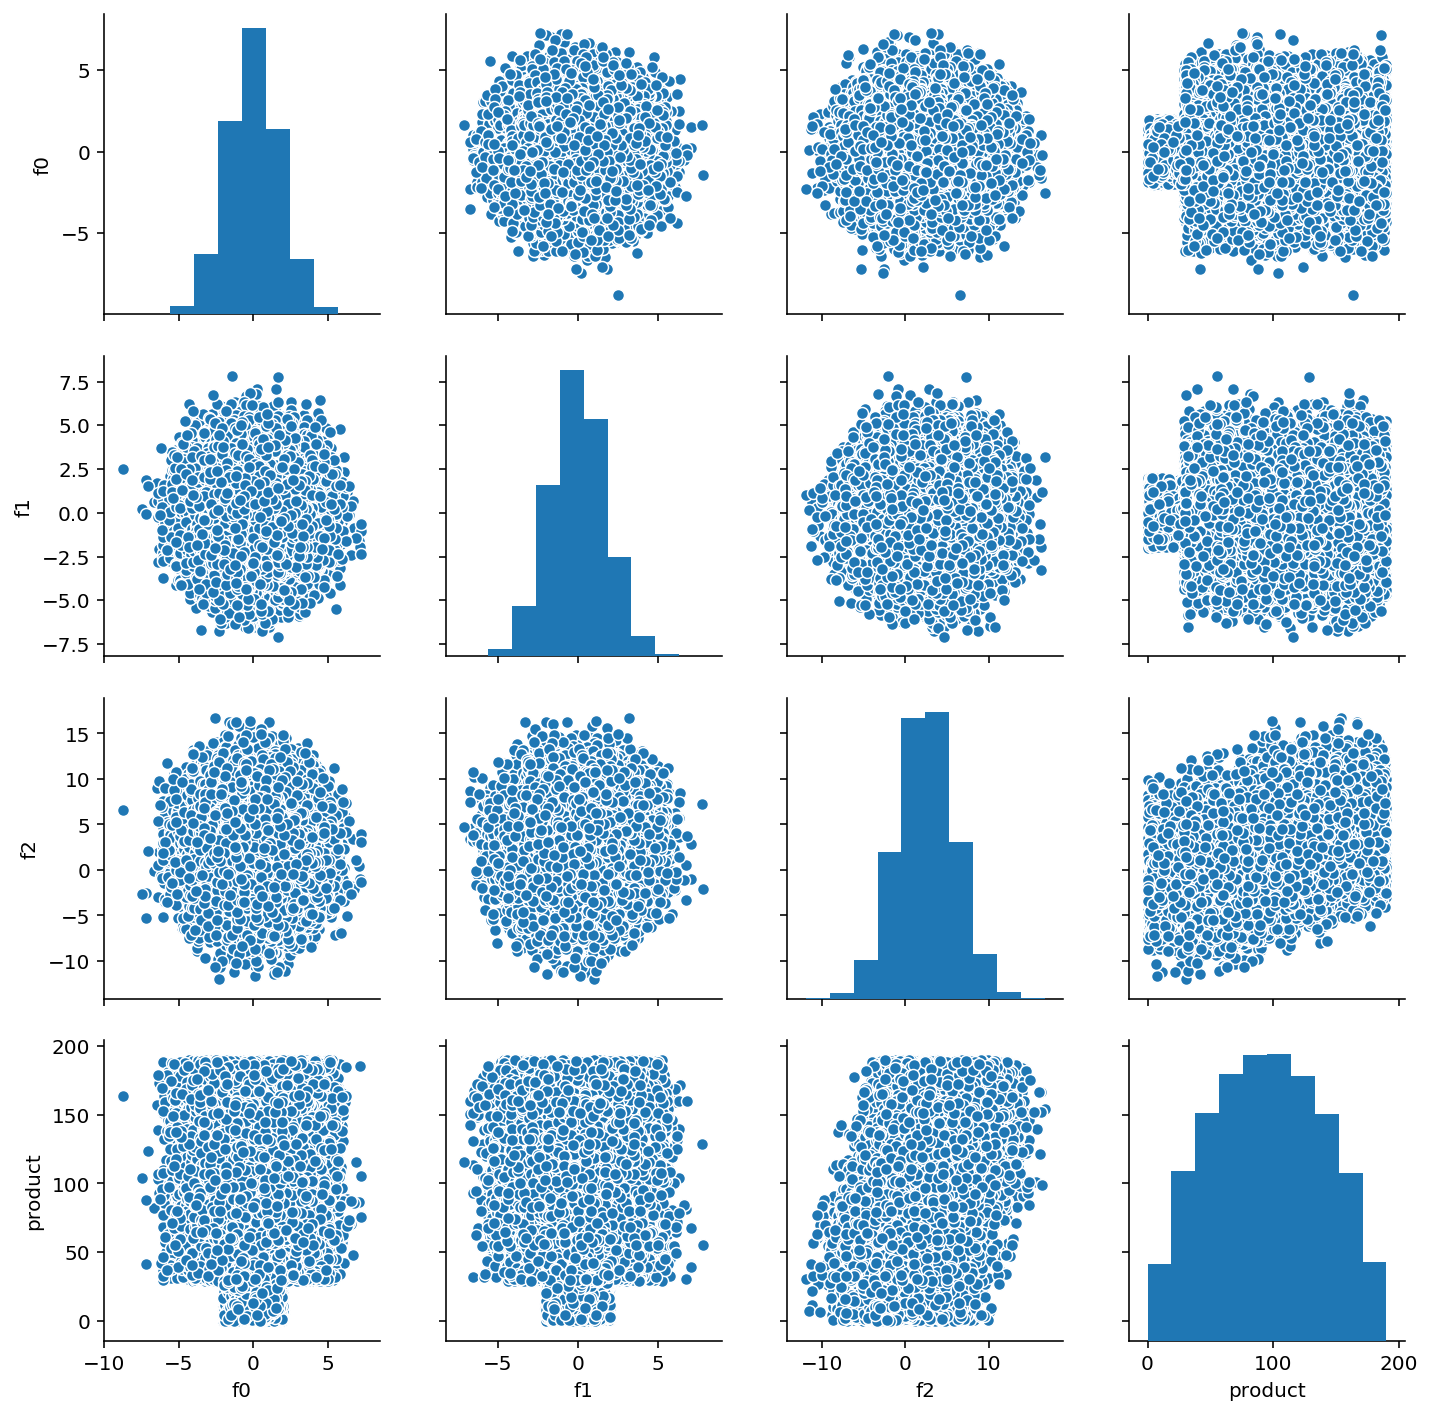

In [7]:
sns.pairplot(df0), sns.pairplot(df1), sns.pairplot(df2);

In all three datasets, the linear dependence of the characteristic f2 with the target characteristic is seen, but in the case of the second dataset, the characteristic f2 is lined up so that the error in linear regression is very small.

It can be seen that in the second location the distribution is different from the other two. It is far from normal and contains several discrete values that repeat - with such a distribution of the target feature and its linear relationship with the feature f2, predicting the number of bariles for this location will be simple

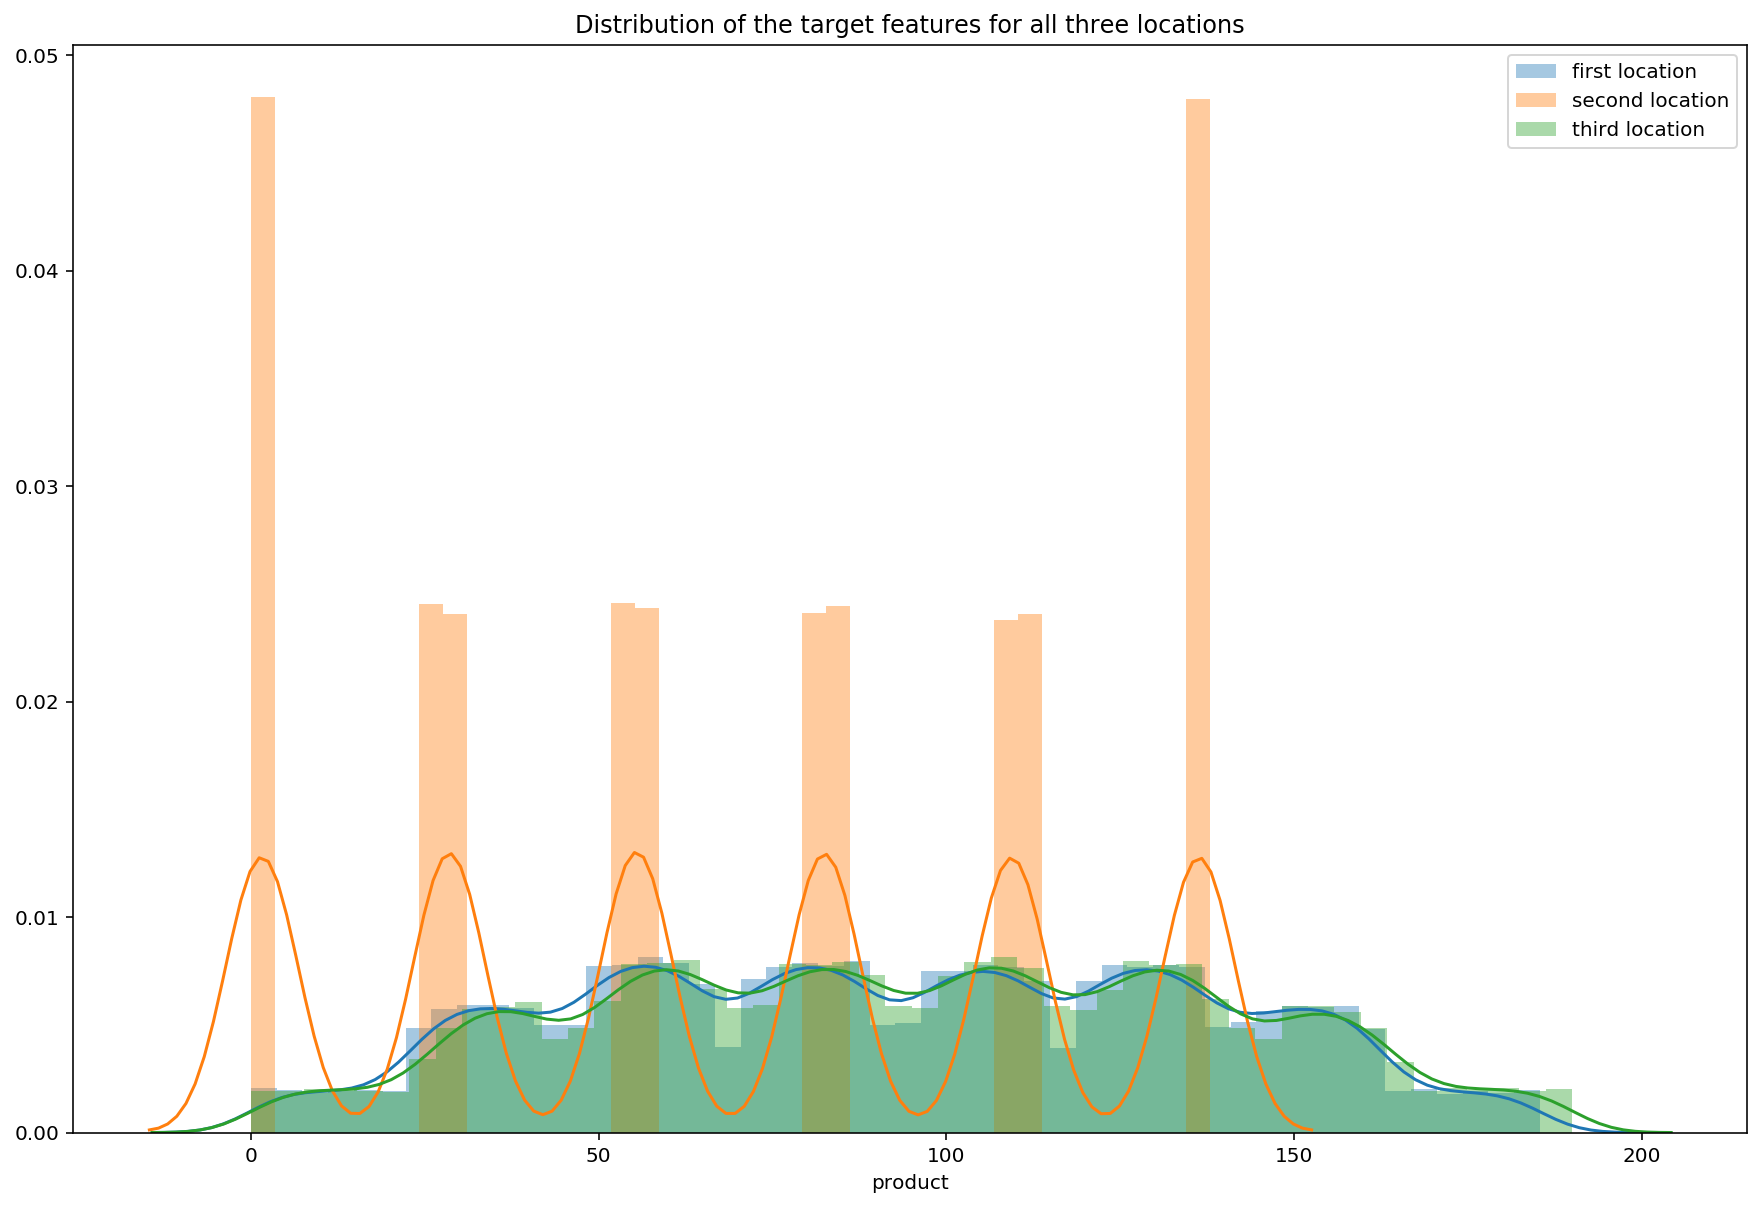

In [8]:
plt.figure(figsize=(15,10))
sns.distplot(df0['product'])
sns.distplot(df1['product'])
sns.distplot(df2['product']);
plt.title('Distribution of the target features for all three locations')
plt.legend(['first location', 'second location', 'third location']);

## Preprocessing

In [9]:
df0 = df0.drop('id', axis=1)
df1 = df1.drop('id', axis=1)
df2 = df2.drop('id', axis=1)

In [10]:
X0 = df0.drop('product', axis=1)
X1 = df1.drop('product', axis=1)
X2 = df2.drop('product', axis=1)

y0 = df0['product']
y1 = df1['product']
y2 = df2['product']

In [11]:
X0_train, X0_val, y0_train, y0_val = train_test_split(X0, y0, test_size = .25, random_state=48)
X0_train.shape, X0_val.shape, y0_train.shape, y0_val.shape

((75000, 3), (25000, 3), (75000,), (25000,))

In [12]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size = .25, random_state=48)
X1_train.shape, X1_val.shape, y1_train.shape, y1_val.shape

((75000, 3), (25000, 3), (75000,), (25000,))

In [13]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size = .25, random_state=48)
X2_train.shape, X2_val.shape, y2_train.shape, y2_val.shape

((75000, 3), (25000, 3), (75000,), (25000,))

In [14]:
scaler0 = StandardScaler()
X0_train = scaler0.fit_transform(X0_train)
X0_val = scaler0.transform(X0_val)

In [15]:
scaler1 = StandardScaler()
X1_train = scaler1.fit_transform(X1_train)
X1_val = scaler1.transform(X1_val)

In [16]:
scaler2 = StandardScaler()
X2_train = scaler2.fit_transform(X2_train)
X2_val = scaler2.transform(X2_val)

# Learning

In [17]:
#First location
model0 = LinearRegression()

model0.fit(X0_train, y0_train)
prediction0 = model0.predict(X0_val)
mse0 = mean_squared_error(y0_val, prediction0)
rmse0 = np.sqrt(mse0)

In [18]:
prediction0 = pd.Series(prediction0, index=y0_val.index)
print(f'Predicted raw oil from first location: {round(prediction0.mean(), 3)} thousands of barrels')
print(f'RMSE = {rmse0}')

Predicted raw oil from first location: 92.32 thousands of barrels
RMSE = 38.0076671743637


In [19]:
#Second location
model1 = LinearRegression()

model1.fit(X1_train, y1_train)
prediction1 = model1.predict(X1_val)
mse1 = mean_squared_error(y1_val, prediction1)
rmse1 = np.sqrt(mse1)

In [20]:
prediction1 = pd.Series(prediction1, index=y1_val.index)
print(f'Predicted raw oil from second location: {round(prediction1.mean(), 3)} thousands of barrels')
print(f'RMSE = {rmse1}')

Predicted raw oil from second location: 68.333 thousands of barrels
RMSE = 0.8989907672881


In [22]:
#Third location
model2 = LinearRegression()

model2.fit(X2_train, y2_train)
prediction2 = model2.predict(X2_val)
mse2 = mean_squared_error(y2_val, prediction2)
rmse2 = np.sqrt(mse2)

In [23]:
prediction2= pd.Series(prediction2, index=y2_val.index)
print(f'Predicted raw oil from third location: {round(prediction2.mean(), 3)} thousands of barrels')
print(f'RMSE = {rmse2}')

Predicted raw oil from third location: 95.016 thousands of barrels
RMSE = 40.072597935168986


In [24]:
mse_df = pd.DataFrame({
     'p_product': [
         prediction0.mean(),
         prediction1.mean(),
         prediction2.mean()
     ],
     'rmse': [
         rmse0,
         rmse1,
         rmse2
     ],
})
mse_df

,p_product,rmse
0,92.320,38.008
1,68.333,0.899
2,95.016,40.073


The first and third locations lead in the amount of predicted raw materials, but their error is also much larger than that of the second location. We need to find a way to compare them and find the most profitable location.

## Calculations

In [25]:
N_LOCATIONS = 500
N_USEFUL_LOCATIONS = 200
BUDGET_PER_REGION = 10**10
REVENUE_PER_UNIT = 450000
LOSS_PROBABILITY_THRESHOLD = 0.025

In [26]:
first_region = pd.Series(prediction0, index=y0_val.index)
second_region = pd.Series(prediction1, index=y1_val.index)
third_region = pd.Series(prediction2, index=y2_val.index)

In [27]:
budget_per_unit = BUDGET_PER_REGION / N_USEFUL_LOCATIONS
min_unit_profit = REVENUE_PER_UNIT / REVENUE_PER_UNIT

print(f'Minimum raw volume per region: {min_unit_profit}')
print('Found mean values 92.32, 68.33, 95.016')

Minimum raw volume per region: 1.0
Found mean values 92.32, 68.33, 95.016


### Conclusion

As we see, in none of the three regions, the average profit goes beyond the desired threshold

## Расчеты

In [28]:
def calc_profit(n_loc_per_region, BUDGET_PER_REGION, REVENUE_PER_UNIT, region):
    profit = region.sort_values(ascending=False).head(n_loc_per_region).sum() * REVENUE_PER_UNIT - BUDGET_PER_REGION
    return '{:.3f} Billion rubles'.format(profit / 10**9 )

In [29]:
print(
    'Total profit from loc. 1',
    calc_profit(N_USEFUL_LOCATIONS, BUDGET_PER_REGION, REVENUE_PER_UNIT, first_region)
)

print(
    'Total profit from loc. 2',
    calc_profit(N_USEFUL_LOCATIONS, BUDGET_PER_REGION, REVENUE_PER_UNIT, second_region))


print('Total profit from loc. 2',
      calc_profit(N_USEFUL_LOCATIONS, BUDGET_PER_REGION, REVENUE_PER_UNIT, third_region))

Total profit from loc. 1 3.973 Billion rubles
Total profit from loc. 2 2.488 Billion rubles
Total profit from loc. 2 3.386 Billion rubles


## Bootstrap

In [30]:
seed = RandomState(888)

In [31]:
def revenue(target, predictions, count):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:count]
    return (selected.sum() * REVENUE_PER_UNIT - 10**10)

In [32]:
def bootstrap(y, prediction):
    values = []
    for i in range(1000):
        sample_predicted = prediction.sort_values(ascending=False).sample(n=N_LOCATIONS, replace=True, random_state=seed)
        sample_target = y[sample_predicted.index]
        values.append(revenue(sample_target, sample_predicted, N_USEFUL_LOCATIONS))

    values = pd.Series(values)

    mean_profit = values.mean()
    confidence_interval = (values.quantile(0.025), values.quantile(0.975))
    loss_probability = (values < 0).mean()

    return (
        f'Average profit: {mean_profit}',
        f'Confidence interval: {confidence_interval}',
        f'Loss probability: {loss_probability}')

In [49]:
#Calc. for loc. 1
bootstrap(y0_val, prediction0)

('Average profit: 422386644.77363855',
 'Confidence interval: (-108504030.67316908, 962358805.4043913)',
 'Loss probability: 0.067')

In [50]:
# Calc. for loc. 2
bootstrap(y1_val, prediction1)

('Average profit: 453473267.08558667',
 'Confidence interval: (33117651.284392603, 880831402.3026074)',
 'Loss probability: 0.015')

In [53]:
#Calc. for loc. 3
bootstrap(y2_val, prediction2)

('Average profit: 462787689.1997811',
 'Confidence interval: (-100349192.18326668, 1001855008.3963305)',
 'Loss probability: 0.048')

## Conclusion

After our analysis the second location looks like the most profitable one:

- Average revenue 45,3 billions
- Loss probability 1.5 %